# Market Regime Oscillatorのデモ

## 市場レジーム判定の基礎コード

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# データ取得（日経平均：^N225）
ticker = "^N225"
df = yf.download(ticker, start="2020-05-01", end="2025-04-30", multi_level_index=False)
df = df[['Close']]

# ボラティリティ計算（20日間のローリング標準偏差）
df['return'] = df['Close'].pct_change()
df['volatility'] = df['return'].rolling(window=20).std()

# 分位点によるレジーム分類
q1 = df['volatility'].quantile(0.33)
q2 = df['volatility'].quantile(0.66)

def classify_regime(vol):
    if vol < q1:
        return 'Low Volatility'
    elif vol < q2:
        return 'Medium Volatility'
    else:
        return 'High Volatility'

df['Regime'] = df['volatility'].apply(classify_regime)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


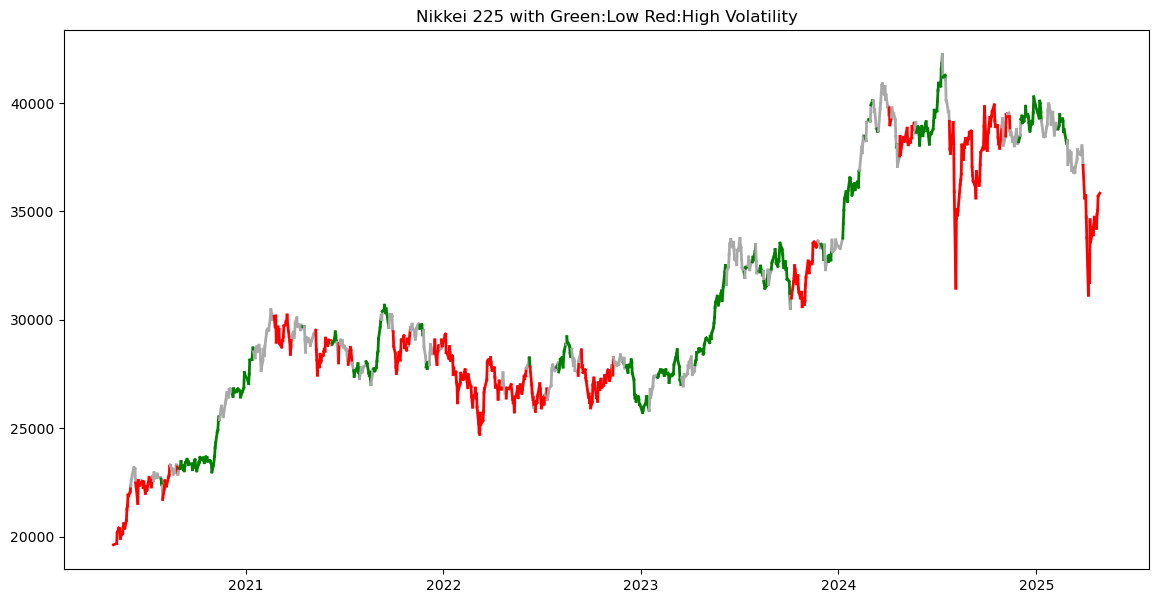

In [3]:
# Plotting with adjusted subplot heights
fig, ax1 = plt.subplots(1, 1, figsize=(14, 7), sharex=True)

# Plotting the close price with the color corresponding to the trend
for i in range(1, len(df)):
    ax1.plot(df.index[i-1:i+1], df['Close'].iloc[i-1:i+1], 
             color='green' if df['Regime'].iloc[i] == 'Low Volatility' else 
                   ('red' if df['Regime'].iloc[i] == 'High Volatility' else 'darkgrey'), linewidth=2)

ax1.set_title('Nikkei 225 with Green:Low Red:High Volatility')
plt.show()

In [4]:
import pandas as pd
import numpy as np
from datetime import date, datetime, timedelta
import matplotlib.pyplot as plt
import yfinance as yf
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [5]:
class MarketRegimeAnalyzer:
    def __init__(self, start_date=None, end_date=None):
        """
        Initialize Market Regime Analyzer

        Args:
            start_date (str, optional): Start date for analysis. Defaults to 3 years ago.
            end_date (str, optional): End date for analysis. Defaults to today.
        """
        # Set default date range if not provided
        if start_date is None:
            start_date = (datetime.now() - timedelta(days=3*365)).strftime('%Y-%m-%d')
        if end_date is None:
            end_date = datetime.now().strftime('%Y-%m-%d')

        self.start_date = start_date
        self.end_date = end_date

        # Tickers for analysis
        self.indices = {
            'NIKKEI': '^N225',
            'VIX': '^NKVI.OS'
        }

        # Data storage
        self.data = {}

    def fetch_data(self):
        """
        Fetch historical data for specified indices

        Returns:
            MarketRegimeAnalyzer: Self with fetched data
        """
        for name, ticker in self.indices.items():
            try:
                # Download data using yfinance with explicit auto_adjust
                # Wrap single ticker in a list to avoid previous error
                df = yf.download([ticker], start=self.start_date, end=self.end_date, auto_adjust=True)

                # If DataFrame has multi-level columns, flatten them
                if isinstance(df.columns, pd.MultiIndex):
                    df.columns = [f'{col[0]}_{col[1]}' for col in df.columns]

                # Ensure numeric columns for calculations
                numeric_columns = ['Open', 'High', 'Low', 'Close']
                for suffix in ['', '_Open', '_High', '_Low', '_Close']:
                    for col in [f'{suffix}' for suffix in numeric_columns]:
                        if col in df.columns:
                            df[col] = pd.to_numeric(df[col], errors='coerce')

                # Add column with ticker name
                df['Ticker'] = name
                self.data[name] = df

            except Exception as e:
                print(f"Error fetching data for {name}: {e}")
                # Verbose error tracking
                import traceback
                traceback.print_exc()

        return self

    def calculate_yang_zhang_volatility(self, ohlc_data, window=21):
        """
        Calculate Yang-Zhang volatility

        Args:
            ohlc_data (pd.DataFrame): OHLC price data
            window (int, optional): Rolling window. Defaults to 21.

        Returns:
            pd.Series: Annualized volatility
        """
        # Identify correct column names
        open_col = [col for col in ohlc_data.columns if 'Open' in col][0]
        high_col = [col for col in ohlc_data.columns if 'High' in col][0]
        low_col = [col for col in ohlc_data.columns if 'Low' in col][0]
        close_col = [col for col in ohlc_data.columns if 'Close' in col][0]

        # Ensure data integrity
        ohlc_data = ohlc_data.dropna(subset=[open_col, high_col, low_col, close_col])

        # Parameters
        k = 0.34  # Standard Yang-Zhang parameter

        # Calculate overnight returns
        overnight_returns = np.log(ohlc_data[open_col] / ohlc_data[close_col].shift(1))
        overnight_vol_sq = overnight_returns.rolling(window=window).var()

        # Open-to-close volatility
        open_close_returns = np.log(ohlc_data[close_col] / ohlc_data[open_col])
        open_close_vol_sq = open_close_returns.rolling(window=window).var()

        # Rogers-Satchell volatility
        rs_terms = (np.log(ohlc_data[high_col] / ohlc_data[open_col]) *
                    np.log(ohlc_data[high_col] / ohlc_data[close_col]) +
                    np.log(ohlc_data[low_col] / ohlc_data[open_col]) *
                    np.log(ohlc_data[low_col] / ohlc_data[close_col]))

        rs_vol_sq = rs_terms.rolling(window=window).mean()

        # Yang-Zhang volatility
        yz_vol_sq = overnight_vol_sq + k * rs_vol_sq + (1 - k) * open_close_vol_sq
        yz_vol = np.sqrt(yz_vol_sq) * np.sqrt(252)  # Annualized

        return yz_vol

    def detect_market_regime(self):
        """
        Detect market regime based on volatility and VIX metrics

        Returns:
            pd.DataFrame: Market regime score and classification
        """
        if not self.data:
            self.fetch_data()

        # Verify data was fetched
        if not self.data or 'NIKKEI' not in self.data or 'VIX' not in self.data:
            raise ValueError("Failed to fetch market data. Please check internet connection and ticker symbols.")

        # Prepare S&P 500 and VIX data
        # Find the correct close column
        NIKKEI_close_col = [col for col in self.data['NIKKEI'].columns if 'Close' in col][0]
        vix_close_col = [col for col in self.data['VIX'].columns if 'Close' in col][0]

        nk225 = self.data['NIKKEI']
        vix = self.data['VIX']

        # Calculate volatility
        nk225_volatility = self.calculate_yang_zhang_volatility(nk225)

        # Calculate volatility metrics with safeguards
        nk225_vol_median = nk225_volatility.rolling(window=252).median()

        # Calculate VIX ratio
        vix_median = vix[vix_close_col].rolling(window=21).median()
        vix_ratio = vix[vix_close_col] / vix_median

        # Regime components calculation with robust handling
        def safe_normalize(series):
            """Safely normalize a series to 0-1 range"""
            min_val = series.min()
            max_val = series.max()
            range_val = max_val - min_val

            # Avoid division by zero
            if range_val == 0:
                return pd.Series(0.5, index=series.index)

            return 1 - ((series - min_val) / range_val)

        # Calculate regime score components
        vol_score = safe_normalize(nk225_volatility)

        # VIX Ratio Score
        vix_ratio_score = safe_normalize(vix_ratio)

        # Additional components
        vol_median_score = (nk225_vol_median > nk225_volatility).astype(float)
        vix_ratio_threshold_score = (vix_ratio < 1).astype(float)

        # Combine components
        regime_score = (
            0.3 * vol_score +
            0.2 * vol_median_score +
            0.3 * vix_ratio_score +
            0.2 * vix_ratio_threshold_score
        ) * 100

        # Classify regime
        def classify_regime(score):
            if pd.isna(score):
                return 'Insufficient Data'
            elif score <= 20:
                return 'Extremely Bearish'
            elif score <= 40:
                return 'Bearish'
            elif score <= 60:
                return 'Neutral'
            elif score <= 80:
                return 'Bullish'
            else:
                return 'Extremely Bullish'

        # Create DataFrame with results
        regime_df = pd.DataFrame({
            'Score': regime_score,
            'Classification': regime_score.apply(classify_regime)
        }, index=nk225.index)

        return regime_df

    def visualize_regime(self, regime_df):
        """
        Visualize market regime analysis

        Args:
            regime_df (pd.DataFrame): Market regime DataFrame
        """
        plt.figure(figsize=(15, 8))

        # Color mapping for different regimes
        color_map = {
            'Extremely Bearish': '#B21818',
            'Bearish': '#EF5350',
            'Neutral': '#9C27B0',
            'Bullish': '#2196F3',
            'Extremely Bullish': '#1565C0',
            'Insufficient Data': '#9E9E9E'
        }

        # Clean out NaN values
        regime_df_clean = regime_df.dropna()

        # Plot regime score
        plt.plot(regime_df_clean.index, regime_df_clean['Score'],
                 linewidth=2,
                 color='gray',
                 alpha=0.7,
                 label='Regime Score')

        # Scatter plot with color-coded points
        for regime in color_map:
            mask = regime_df_clean['Classification'] == regime
            subset = regime_df_clean[mask]
            if not subset.empty:
                plt.scatter(subset.index,
                            subset['Score'],
                            c=color_map[regime],
                            label=regime,
                            alpha=0.7)

        plt.title('Market Regime Analysis', fontsize=15)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Regime Score', fontsize=12)
        plt.ylim(0, 100)
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

    def run_analysis(self):
        """
        Run complete market regime analysis

        Returns:
            pd.DataFrame: Market regime results
        """
        regime_df = self.detect_market_regime()
        self.visualize_regime(regime_df)
        return regime_df

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


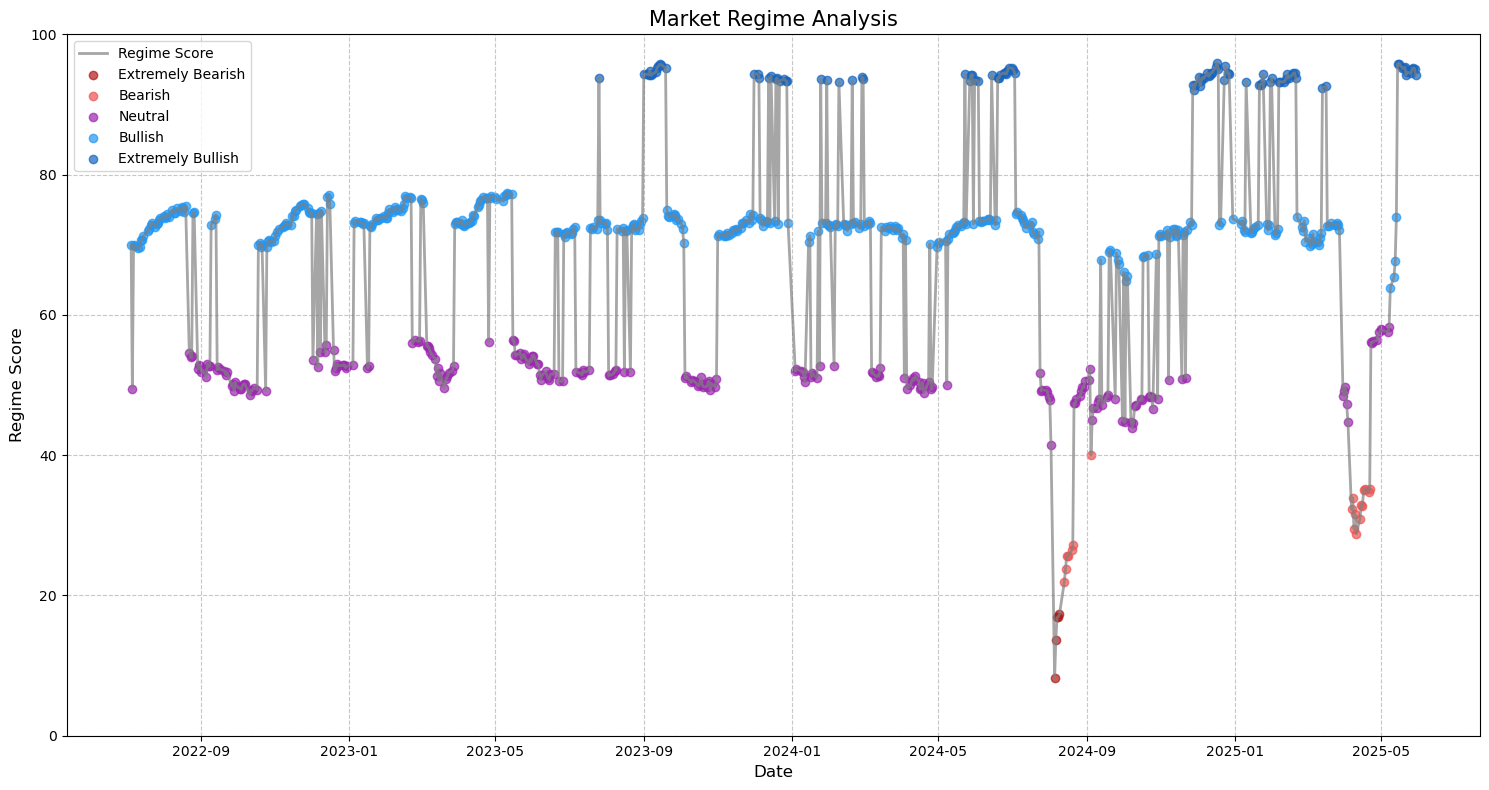


Most Recent Market Regime:
                Score     Classification
Date                                    
2025-05-30  94.180468  Extremely Bullish

Regime Summary Statistics:
                   Score                                             \
                   count       mean       std        min        25%   
Classification                                                        
Bearish             19.0  30.707430  4.701703  21.919678  26.845864   
Bullish            360.0  72.785435  2.034759  63.881192  71.852347   
Extremely Bearish    5.0  14.603269  3.864170   8.206829  13.681343   
Extremely Bullish   99.0  94.138225  0.829515  92.092767  93.574687   
Insufficient Data    0.0        NaN       NaN        NaN        NaN   
Neutral            225.0  51.221665  2.731637  41.518110  49.658957   

                                                    
                         50%        75%        max  
Classification                                      
Bearish            31.

In [6]:
# Example usage
if __name__ == "__main__":
    # Initialize and run analysis
    analyzer = MarketRegimeAnalyzer()
    results = analyzer.run_analysis()

    # Print most recent regime details
    print("\nMost Recent Market Regime:")
    most_recent = results.dropna().tail(1)
    print(most_recent)

    # Print summary statistics
    print("\nRegime Summary Statistics:")
    summary_stats = results.groupby('Classification').describe()
    print(summary_stats)

    # Additional insights
    print("\nRegime Distribution:")
    regime_distribution = results['Classification'].value_counts(normalize=True) * 100
    print(regime_distribution)